# K channels: inactivation

#### **Basic instructions:**
#### 1. **To run code cells**, you can either hit the play button to the left of the cell, or you can select the cell and **press shift-enter**.

#### 2. **The first time** you run this code notebook, you might get a popup asking to choose which version of Python to use (the python "kernel"). **Just hit enter** to choose the base/default version.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files over from where they are saved on your computer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()

## 1. Choose the data file you want to analyze

#### Put the .abf files with your K channel recordings in the "data/K_channels" folder

In [6]:
data_folder = "data/2-K_channels"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/2-K_channels


['data/2-K_channels/K_IV.abf',
 'data/2-K_channels/K_deact_1.abf',
 'data/2-K_channels/K_deact_3.abf',
 'data/2-K_channels/K_deact_2.abf',
 'data/2-K_channels/2024_06_08_0007.abf',
 'data/2-K_channels/2024_06_08_0013.abf',
 'data/2-K_channels/2024_06_08_0014.abf']

Choose which file you want to analyze and past the file name here:

In [12]:
# data_file = 'data/2-K_channels/2024_06_08_0007.abf'
# data_file = 'data/2-K_channels/2024_06_08_0014.abf'

data_file = 'data/2-K_channels/K_deact_3.abf'

Now we can load the file and plot the raw data:

Trace('K_deact_3.abf')
Number of sweeps: 11
Points per sweep: 28,500
Duration per sweep: 0.570 s
Sampling rate: 50000 Hz
Sampling interval: 0.020 ms
Available channels: Current, Voltage, TTL


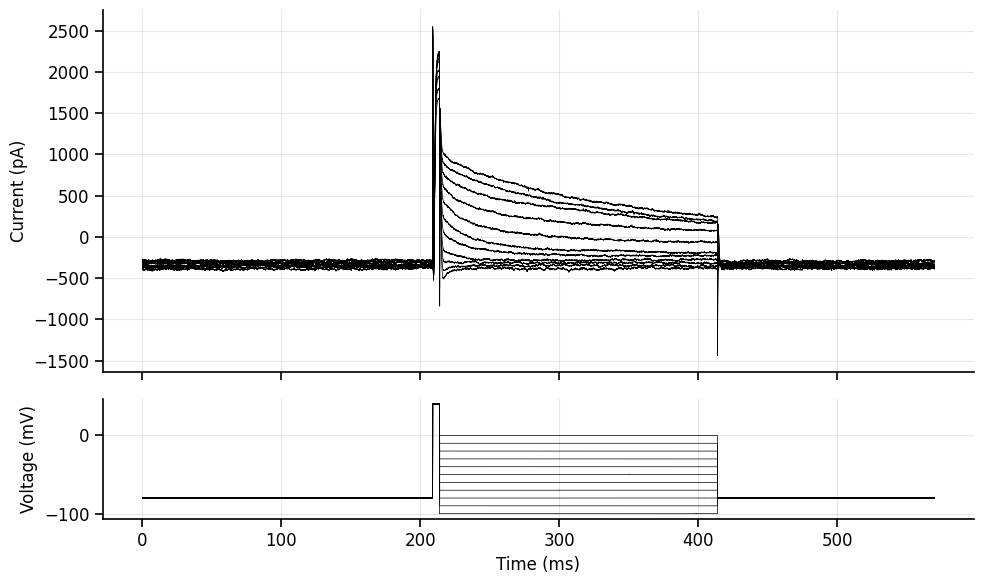

In [15]:
traces = Trace.from_axon_file(filename=data_file, 
                              load_voltage=True, 
                              load_ttl=True,
                              units=['pA', 'mV', 'V'], 
                              concatenate_sweeps=False)
print(traces)

time_units = 'ms' # specify seconds (s), or milliseconds (ms)

# ----------------------------------------------------------------------------------------------------------------
%matplotlib inline
traces.plot(plot_voltage=True, sweep='all', time_units=time_units)
plt.show()

## 2. Signal processing

### 2.1. Optional: apply baseline correction

If your baseline current is not zero, you may need to correct for that to get accurate measurements.

Uncomment this cell block (highlight everything, then cmd+/ on macOS or ctrl+/ on Windows) to run it.

In [ ]:
# Change this to True if you want to subtract the baseline from the sweeps.
subtract_baseline = True

In [ ]:
if subtract_baseline:
    traces.subtract_baseline(start_time = 0, 
                             end_time = 0.1, 
                             time_units = time_units,  # specify seconds (s), or milliseconds (ms)
                             channel = 'current')  # Options: 'current', 'voltage', 'all'
    %matplotlib widget
    ax1, ax2 = traces.plot(plot_voltage=True, plot_ttl=False, time_units=time_units, sweep='all')
    ax1.set_title('After baseline subtraction', y=0.98)
    plt.show()
else:
    print("BASELINE NOT SUBTRACTED")


### 2.2. Optional: apply additional highpass/lowpass filtering

Depending in you recording, you may have 50/60 Hz line noise, high-frequency noise, or drift in your recordings.

The goal here is to only remove the noise with minimal distortion of the data, so be careful not to overdo it

In [ ]:
# Change this to True if you want to subtract the baseline from the sweeps.
additional_filtering = False

In [ ]:
if additional_filtering:
    filtered_traces = traces
    # Step 1: Detrend the data to remove linear or constant trends.
    filtered_traces = filtered_traces.detrend(detrend_type='linear', num_segments=1)

    # Step 2: Apply a highpass filter to remove low-frequency noise + lowpass to remove high-frequency noise
    filtered_traces = filtered_traces.filter(
        line_freq=60,    # Frequency (Hz) of electrical noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
        width=0.5,         # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
        highpass=0.5,   # Removes low-frequency drift. Set a value in Hz (e.g. 1 for 1 Hz).
        lowpass=4900,    # Removes high-frequency noise. Set a value in Hz (e.g. 100 for 100 Hz).
        order=4)         # Controls sharpness of the filter. Higher = sharper cutoff.

    %matplotlib widget
    ax = filtered_traces.plot(plot_voltage=False, plot_ttl=False)
    ax.set_title('After filtering', y=0.98)
    plt.show()

Once you are happy with the filter setting, run the next cell to implement them:

In [ ]:
if additional_filtering:
    traces=filtered_traces

## 3. Select what you want to measure

### 3.1. Defining the time window

First let's define the relevant time window where we want to measure the currents:

(If you want to save the images, you can do it by clicking on the save icon in the top-right of the image when you hover over it)

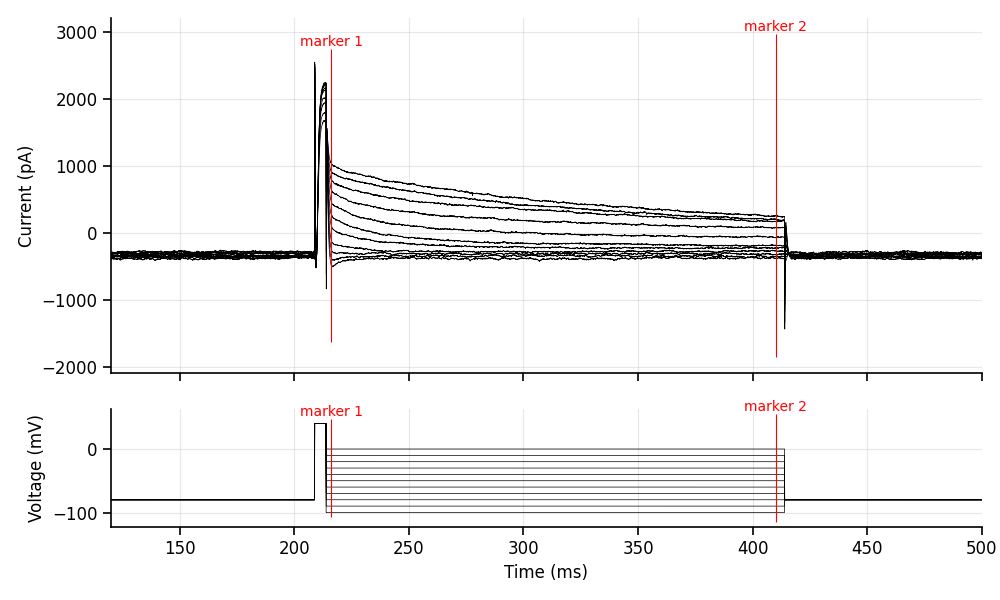

In [36]:
# The start/end time just helps to zoom in on the traces.
start_time = 120
end_time = 500

# The markers are important: the will define the window where we actually exctract peak current values from. Set them carefully.
marker_1 = 216.2
marker_2 = 410

# ----------------------------------------------------------------------------------------------------------------------
%matplotlib widget
ax1,ax2 = traces.plot(plot_voltage=True, time_units=time_units, marker_1=marker_1, marker_2=marker_2, sweep='all')
ax1.set_xlim(start_time,end_time)
ax2.set_xlim(start_time,end_time)
plt.show()

### 3.2. Measure the instantaneous currents (when channels are open)

Here we will be using the timepoints from the markers we defined above and get the peak currents in that time window.

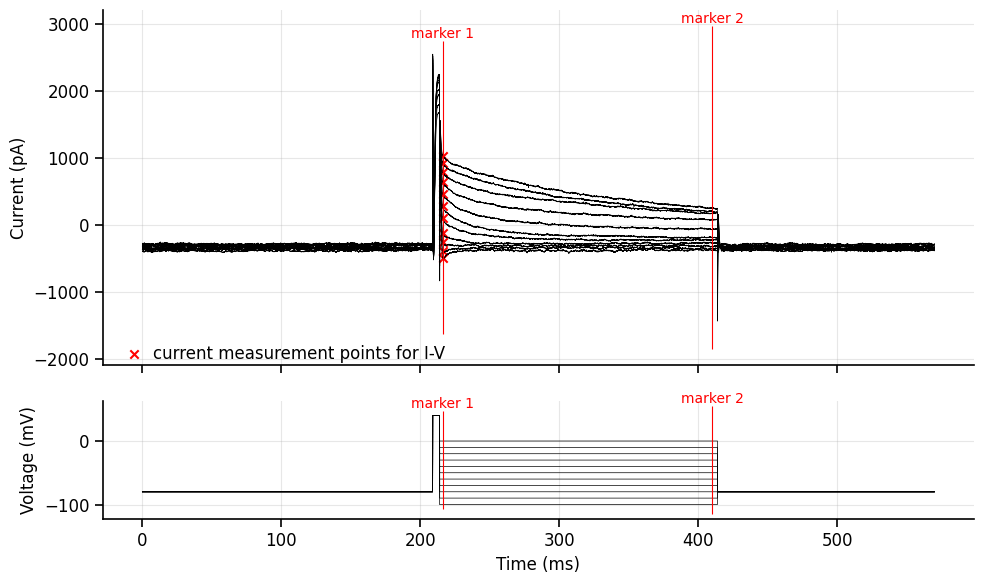

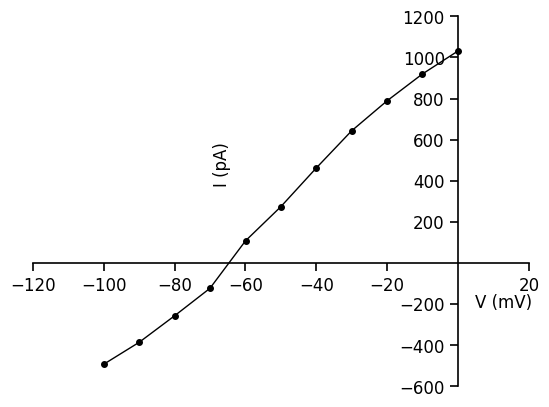

In [37]:
current_steps ,voltage_steps = traces.get_measurements(start_time=marker_1, end_time=marker_1+0.1, time_units=time_units, sweep='all', measurement_type='peak')

%matplotlib inline
ax1,ax2 = traces.plot(plot_voltage=True, time_units=time_units, marker_1=marker_1, marker_2=marker_2, sweep='all')
ax1.scatter([marker_1]*len(current_steps), current_steps, color='red', marker='x', label="current measurement points for I-V")
ax1.legend(loc='upper left', bbox_to_anchor=(0., 0.1))
plt.show()
ax = plot_IV(voltage_steps, current_steps, xlabel_coords=(0.95,0.25), ylabel_coords=(0.4,0.6))
plt.show()


### 3.3. Optional: fit a line to the I-V points to estimate the reversal potential and conductance

G = slope = 16.263 nS
Resistance = 1/slope = 61.488 MOhm
Reversal potential: -66.543 mV


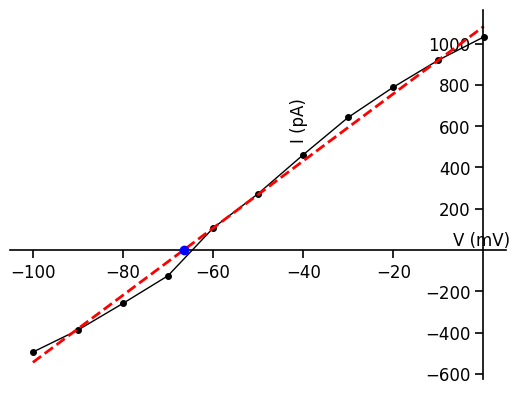

In [ ]:
ax = plot_IV(voltage_steps, current_steps, xlabel_coords=(0.95,0.4), ylabel_coords=(0.6,0.7))

# Fit a line to the points
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(voltage_steps, current_steps)
ax.plot(voltage_steps, slope * voltage_steps + intercept, linestyle='--', color='r', label='Fit', linewidth=2)

print(f"G = slope = {slope:.3f} nS")
print(f"Resistance = 1/slope = {1/slope * 1000:.3f} MOhm")

# Find the intercept on the x-axis (where current is zero) to get E_rev (reversal potential)
E_reve = -intercept / slope
ax.scatter(E_rev, 0, color='b', zorder=5)
print(f"Reversal potential: {E_rev:.3f} mV")
plt.show()

### 3.4. Measure the decay timeconstant of the currents (fit an exponential to the current decay)

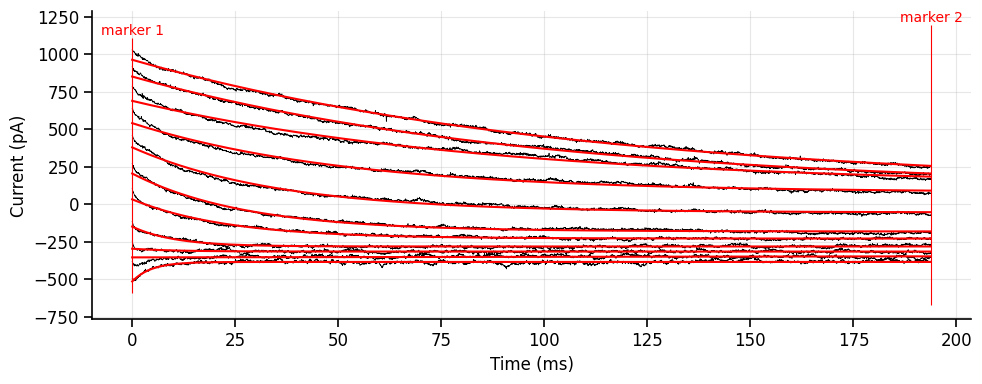

In [66]:
# We need an initial guess for fitting the exponential curve
# (if the fit doesn't work, try to change this value))
tau_guess = 100 # milliseconds

# If the fit still doesn't work, try to change the position of marker 1


# -----------------------------------------------------------------------------------------------------------------
cropped_traces = traces.crop(timepoint=marker_1, timepoint_2=marker_2, time_units=time_units)
ax = cropped_traces.plot(plot_voltage=False, time_units=time_units, marker_1=0, marker_2=(marker_2-marker_1), sweep='all')

current_between_markers = cropped_traces.current_data
voltage_steps = list(cropped_traces.voltage_data[:, 0])
time_ms = cropped_traces.time_ms

def exponential_curve(time, I0, tau, I_inf):
    return I0 * np.exp(-time / tau) + I_inf

tau_values = []
for i, trace in enumerate(current_between_markers):
    I0_guess = trace[0]
    I_inf_guess = trace[-1]
    try:
        fit_params,_ = curve_fit(exponential_curve, time_ms[0:], trace[0:], 
                                    p0=[I0_guess, tau_guess, I_inf_guess], maxfev=1000000)
        V0_fit, tau_fit, Vinf_fit = fit_params
        tau_values.append(tau_fit)

        if np.abs(tau_fit) > 1000: # Remove outliers (bad fits), we are not expecting a tau > 1 second for these currents
            tau_values.pop()
            voltage_steps.pop(i)

        # Overlay fit
        fit_trace = exponential_curve(time_ms[0:], *fit_params)
        ax.plot(time_ms[0:], fit_trace[0:], color='r', alpha=1, linewidth=1.5)
    except RuntimeError:
        print("Error fitting trace")
        tau_values.append(np.nan)
        continue
plt.show()

Finally, let's plot the the decay timeconstant vs the voltage steps applied.

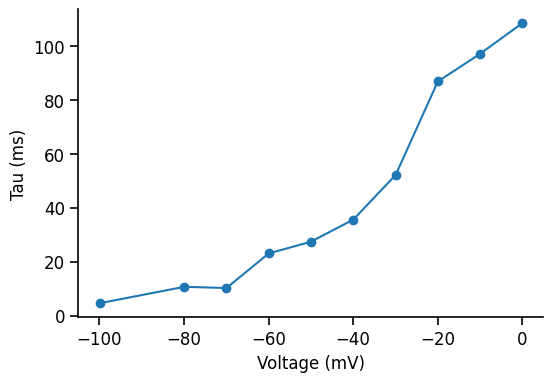

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(voltage_steps, tau_values, 'o-')
ax.set_ylabel('Tau (ms)')
ax.set_xlabel('Voltage (mV)')
plt.show()  